In [ ]:
!pip install umap

In [ ]:
pip freeze > requirements.txt

In [ ]:
pip install -r requirements.txt

## Import libraries

In [ ]:
path = ''

In [ ]:
import numpy as np
from sklearn import datasets
import pandas as pd
# import umap
from copy import deepcopy
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from google.colab import files
import plotly.express as px

# Calculate distance

In [ ]:
def calculate_norm(x, norm):
    if norm == 'l1':
        return np.sum(np.abs(x))
    elif norm == 'euclidean':
        return np.sqrt(np.sum(np.square(x)))
    elif norm == 'linf':    
        return np.max(np.abs(x))
    elif norm == 'cosine':
        return np.sum(x)/np.sqrt(np.sum(np.square(x)))
    elif norm == 'mahalanobis':
        return np.sqrt(np.sum(np.square(x)))
    else:
        return np.sqrt(np.sum(np.square(x[:, np.newaxis] - x), axis=2))

def calculate_dist(x1, x2, norm):
    '''this method calculated the distance between matrix
        with different norms'''

    dist = np.zeros((len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            dist[i, j] = calculate_norm(x1[i] - x2[j], norm)

    return dist

# Shuffle and Sampling function

In [ ]:
def shuffled_sampling(data, k, v):
  '''
    Este método hace un sampleo de los datos, separando en proporción k
    para entrenamiento y 1-k-v para test  y 1-k-v para validación.
    '''
  n = data.shape[0]
  m = int(k*n)
  l = int(v*n)
  data = data.sample(frac=1).reset_index(drop=True)
  data = data.sample(frac=1).reset_index(drop=True)
  train_data = data.iloc[:m,:]
  test_data = data.iloc[m:m+l,:]
  val_data = data.iloc[m+l:,:]

  return train_data, test_data, val_data

# Normalization

In [ ]:
def normalization(x, n):
  # Normalization
  for i in range(n):
      maxx = max(x[:,i])
      x[:,i] = x[:,i]/maxx

  return x

# Plotting

In [ ]:
def plot_clusters(X, centers, clusters, path, ra, rb, k, algorithm, norm, i, j):
    plt.scatter(np.array(X[:, i]), np.array(X[:, j]), c=clusters)
    # plt.scatter(centers[:, 0], centers[:, 1], marker="x", color="k", s=150, linewidth=5)
    plt.title(str(algorithm)+', '+', ra='+str(ra)+', rb='+str(rb)+', K='+str(k)+', norm='+str(norm))
    # plt.savefig('/content/fig_fuz/'+str(algorithm)+'ra'+str(ra)+'rb'+str(rb)+'K'+str(k)+str(norm)+str(j)+".png")
    # files.download('figures'+str(algorithm)+'ra'+str(ra)+'rb'+str(rb)+'K'+str(k)+str(norm)+".png")
    plt.show()


# Clustering methods

## Calculate density

In [ ]:
def calculate_density(x, center, ra, rb, norm, method):
    '''this method calculates the density of a point'''
    if method == 'mountain':
        dist = calculate_dist(center, x, norm)
        dens = np.sum(np.exp(-dist**2/(2*ra**2)))
    elif method == 'subtractive':
        dist = calculate_dist(center, x, norm)
        dens = np.sum(np.exp(-dist**2/((ra/2)**2)), axis=0)
    return dens

## Mountain algorithm

In [ ]:
# x = np.matrix([[2,3,4],[1,2,3]])

def make_grid(min_cor, max_cor, n, h):
    '''this method creates a n-dimensional grid of points
    with a given step size'''
    # initialize the grid
    grid = np.zeros((n, n))
    # initialize the coordinates
    cor = np.linspace(min_cor, max_cor, int((max_cor-min_cor)/h))
    # create the grid
    for i in range(n):
        for j in range(n):
            grid[i, j] = cor[i] + 1j*cor[j]

    return grid

def mountain_clustering(x, K, ra, rb, norm):
    '''this method estimates the clustering centers
    through the Mountain Algorithm'''

    grid = make_grid(x[:, 0], x[:, 1], 0.1)
    grid = x

    dens = calculate_density(grid, x, ra, rb, norm, 'mountain')

    for i in range(K):        
        center = x[np.argmax(dens)]
        dens_cen = calculate_density(center, x, ra, rb, norm, 'mountain')
        dens = dens - dens_cen*np.exp(-calculate_dist(x, center, norm)**2/(2*ra**2))

    return center, dens

## Subtractive clustering

In [ ]:
def subtractive_clustering(x, max_iterations, ra, rb, norm):
    '''this method estimates the clustering centers
    through the Subtractive Clustering Algorithm'''

    dens = calculate_density(x, x, ra, rb, norm, 'subtractive')
    centers = []
    clusters = np.zeros(x.shape[0])
    ind = np.array(range(x.shape[0]))
    it = 0

    while x.shape[0] > 0 and it < max_iterations:        
        center = x[np.argmax(dens),:]
        centers.append(center)
        x = np.delete(x, np.argmax(dens), axis=0)
        dens = np.delete(dens, np.argmax(dens))
        dens_cen = calculate_density(x, center, ra, rb, norm, 'subtractive')
        dens = dens - np.matrix(dens_cen)*np.exp(-calculate_dist(x, np.matrix(center), norm)**2/((rb/2)**2))
        dens = np.array(dens)
        x = x[dens[0] < rb, :]
        dens = dens[0,dens[0] < rb]
        clusters[ind[np.argmax(dens)]] = it
        clusters[ind[np.where(dens[0] < rb)]] = it
        it+=1

    return centers, clusters

## K means

In [ ]:
def kmeans_clustering(x, K, tol, max_iterations, norm):
    '''this method estimates the clustering centers
    through the K-means Algorithm'''

    centers = x[np.random.choice(len(x), K, replace=False), :]

    labels = np.zeros(len(x))
    U = np.zeros((len(x), K))
    change = 1
    it = 0

    while change > tol and it < max_iterations:
        U = calculate_dist(x, centers, norm)
        
        labels = np.argmin(U, axis=1)
        
        centers_old = centers.copy()
        for i in range(K):
            centers[i, :] = np.mean(x[labels == i, :], axis=0)
        
        change = np.sum(np.abs(centers - centers_old))
        it += 1

    return centers, labels

## Fuzzy C-means

In [ ]:
def fuzzy_cmeans_clustering(x, K, tol, max_iterations, norm, m):
    '''this method estimates the clustering centers
    through the fuzzy c-means Algorithm'''

    U = np.random.rand(len(x), K)
    U = U/np.sum(U)

    centers = np.zeros((x.shape[1], K))
    it = 0
    J=np.array([1])
    labels = np.zeros(len(x))

    while it < max_iterations and J > tol:
        centers_old = deepcopy(centers)
        for i in range(K):
            num = U[:, i].T@x
            den = np.sum(U[:, i])
            # centers[:, i] = np.sum(U[:, i]*x)/np.sum(U[:, i])
            centers[:, i] = num/den
        
        for i in range(len(x)):
          for j in range(K):
            dist_cen = calculate_dist(x, centers[:, j], norm)
            ex = 2/(m-1)
            U[i, j] = (dist_cen[i,j]**ex)/(np.sum(dist_cen[i, :]**ex))
            U[i, j] = 1/U[i, j]

        #labels
        labels = np.argmin(U, axis=1)

        J = sum([np.sum(U[:, i]**m*calculate_dist(x, centers[:, i], norm)[:, i]**2) for i in range(K)])

        if np.linalg.norm(centers - centers_old) < tol:
            break

        it += 1
    return centers, labels

## Trimmed k mean

In [ ]:
def trimmed_kmeans_clustering(X, k, maxIters, norm, trim=0.1):
    '''this method estimates the clustering centers
    through the trimmed K-means Algorithm'''
    centers = X[np.random.choice(np.arange(len(X)), k, replace=False), :]
    prev_centroids = np.zeros(centers.shape)
    clusters = np.zeros(len(X))
    distances = np.zeros((len(X), k))
    iters = 0
    while iters < maxIters:
        iters += 1
        prev_centroids = deepcopy(centers)
        distances = calculate_dist(X, centers, norm)
        clusters = np.argmin(distances, axis=1)
        for i in range(k):
            centers[i, :] = stats.trim_mean(X[clusters == i, :], trim)
        if np.all(centers == prev_centroids):
            break

    return centers, clusters

# Datos de juguete

In [ ]:
# Read data
x, y = datasets.load_iris(return_X_y=True)
for i in range(x.shape[1]):
  maxx = max(x[:,i])
  x[:,i] = x[:,i]/maxx

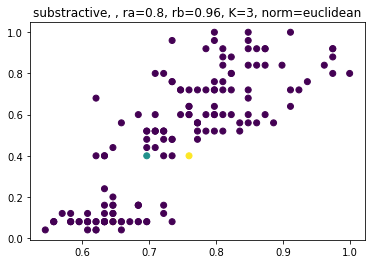

In [ ]:
# Subtractive algorithm
K = 3
ra = 0.8
rb = 1.2*ra
norm = 'euclidean'
centers, labels = subtractive_clustering(x, K, ra, rb, norm)
plot_clusters(x, centers, list(labels), path, ra, rb, len(centers), 'substractive', norm, 0, 3)

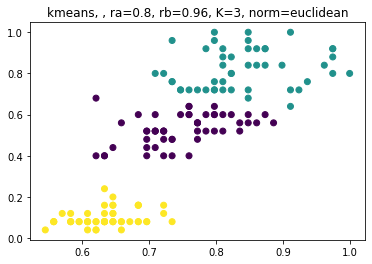

In [ ]:
# K means algorithm
K = 3
tol = 0.0001
norm = 'euclidean'
max_iterations = 50

centers, labels = kmeans_clustering(x, K, tol, max_iterations, norm)
plot_clusters(x, centers, list(labels), path, ra, rb, len(centers), 'kmeans', norm, 0, 3)

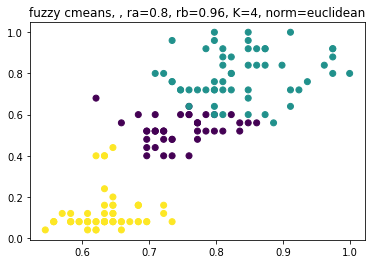

In [ ]:
# Fuzzy C means algorithm
K = 3
tol = 0.001
norm = 'euclidean'
max_iterations = 50
m = 0.5

centers, labels = fuzzy_cmeans_clustering(x, K, tol, max_iterations, norm, m)
plot_clusters(x, centers, list(labels), path, ra, rb, len(centers), 'fuzzy cmeans', norm, 0, 3)

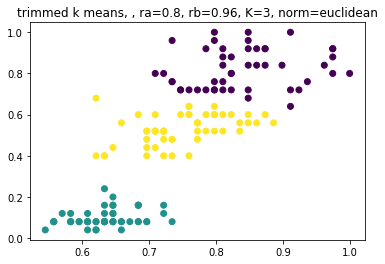

In [ ]:
# Trimmed K means algorithm
K = 3
tol = 0.0001
norm = 'euclidean'
max_iterations = 50

# centers, labels = trimmed_kmeans_clustering(x, K, tol, max_iterations, norm)
centers_tkm, labels = trimmed_kmeans_clustering(x, K, max_iterations, norm, trim=0.1)
plot_clusters(x, centers, list(labels), path, ra, rb, len(centers), 'trimmed k means', norm, 0, 3)

# Movies Dataset

## Data reading and parsing

In [ ]:
# movies_df = pd.read_csv(r'/content/drive/MyDrive/Supervised_learning_IA_Juliana_Henao/movies_industry_oscars.csv')
movies_df = pd.read_csv(r'data/movies_industry_oscars.csv')

# Sampling
n_train = 1
n_val = 0
X, test_data, val_data = shuffled_sampling(movies_df, n_train, n_val)

X = np.matrix(X.iloc[:, 0:8])

n = X.shape[1]

x = normalization(X, n)

## Visualization

In [ ]:
fig = px.scatter_matrix(movies_df.iloc[:,1:8], dimensions=movies_df.iloc[:,1:8].columns)
fig.show()

## Subtractive

In [ ]:
# Subtractive algorithm
K = 2
ra = 0.7
rb = 1.5*ra
norm = 'euclidean'
centers, clusters = subtractive_clustering(X, K, ra, rb, norm)

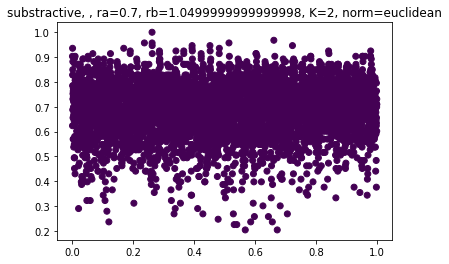

In [ ]:
plot_clusters(X, centers, list(clusters), path, ra, rb, len(centers), 'substractive', norm)

## K means

In [ ]:
# K means algorithm
K = 2
tol = 0.0001
norm = 'euclidean'
max_iterations = 50

centers_km, labels = kmeans_clustering(X, K, tol, max_iterations, norm)

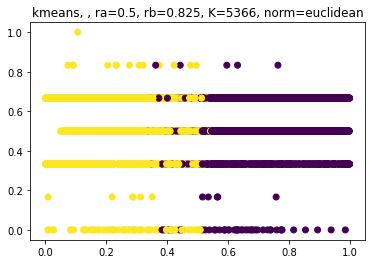

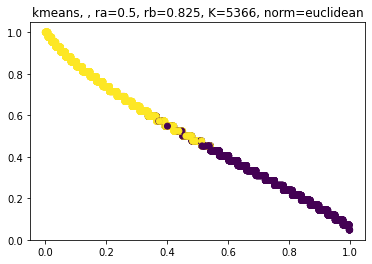

In [ ]:
plot_clusters(X, centers, list(labels), path, ra, rb, len(labels), 'kmeans', norm, 0, 1)
plot_clusters(X, centers, list(labels), path, ra, rb, len(labels), 'kmeans', norm, 0, 3)

## Fuzzy C-means

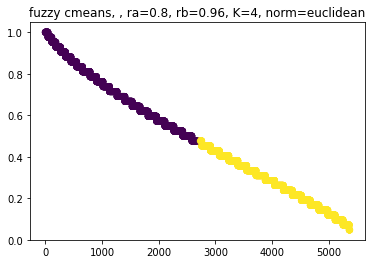

In [ ]:
# Fuzzy c-means algorithm
K = 2
tol = 0.0001
norm = 'euclidean'
max_iterations = 30
m = 0.5

centers, labels = fuzzy_cmeans_clustering(X, K, tol, max_iterations, norm, m)
plot_clusters(X, centers, list(labels), path, ra, rb, len(centers), 'fuzzy cmeans', norm, 0, 3)

## Trimmed k-means

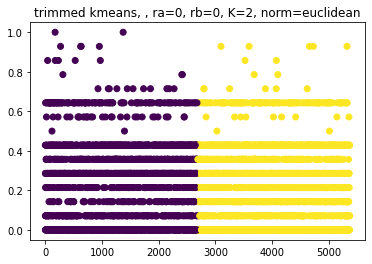

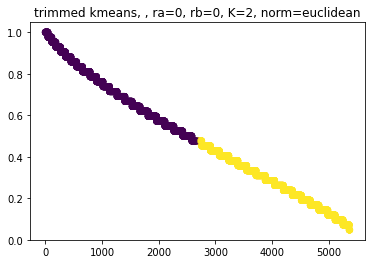

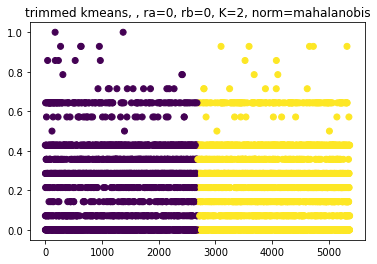

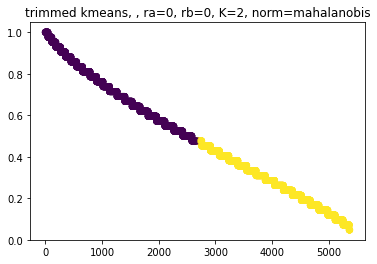

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


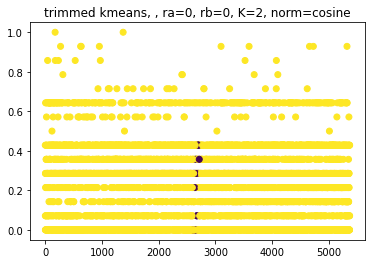

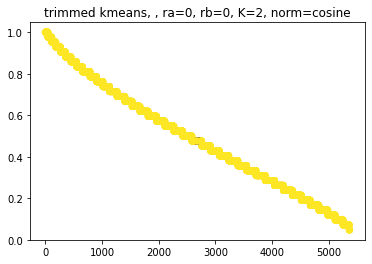

In [ ]:
K  = 2
tol = 0.001
max_iterations = 50
ra = 0
rb = 0
for norm in ['euclidean', 'mahalanobis', 'cosine']:  
    centers, labels = trimmed_kmeans_clustering(X, K, max_iterations, norm, trim=0.1)
    plot_clusters(X, centers, list(labels), path, ra, rb, len(centers), 'trimmed kmeans', norm, 0, 2)
    plot_clusters(X, centers, list(labels), path, ra, rb, len(centers), 'trimmed kmeans', norm, 0, 3)

## Main

In [ ]:
tol = 0.001
max_iterations = 50

for norm in ['euclidean', 'mahalanobis', 'cosine']:  
  for K in [2, 3]:
    centers, clusters = kmeans_clustering(X, K, tol, max_iterations, norm)
    plot_clusters(X, centers, list(labels), path, ra, rb, len(centers), 'kmeans', norm, 0, 2)
    plot_clusters(X, centers, list(labels), path, ra, rb, len(centers), 'kmeans', norm, 0, 3)

    centers, labels = trimmed_kmeans_clustering(X, K, max_iterations, norm, trim=0.1)
    plot_clusters(X, centers, list(labels), path, ra, rb, len(centers), 'trimmed kmeans', norm, 0, 2)
    plot_clusters(X, centers, list(labels), path, ra, rb, len(centers), 'trimmed kmeans', norm, 0, 3)

    centers, labels = fuzzy_cmeans_clustering(x, K, tol, max_iterations, norm, m)
    plot_clusters(x, centers, list(labels), path, ra, rb, len(centers), 'fuzzy cmeans', norm, 0, 3)
  for ra in [0.5, 0.8]:
      rb = 1.65*ra
      centers, labels = subtractive_clustering(X, K, ra, rb, norm)
      plot_clusters(X, centers, list(labels), path, ra, rb, len(centers), 'substractive', norm, 0, 2)
      plot_clusters(X, centers, list(labels), path, ra, rb, len(centers), 'substractive', norm, 0, 3)